In [1]:
!unzip glove.6B.50d.zip  # to extract word vectors

Archive:  glove.6B.50d.zip
  inflating: glove.6B.50d.txt        


In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import os                                         # importing required libraries
import time
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import RNN

In [3]:
def getVocab(filename,d_model): # to generate word-num-vector mapping using pre trained word vectors
    
    file = open(filename,'r')
    
    num     = 0
    vocab_num_to_vector = {}
    vocab_word_to_num   = {}
    vocab_num_to_vector[num] = np.zeros((d_model))
    vocab_word_to_num['ukn'] = num
    num+=1

    for lines in file:
        values = lines.split()
        word   = values[0]
        vector = list(map(float,values[1:]))
        vocab_num_to_vector[num] = np.array(vector)
        vocab_word_to_num[word]  = num
        num+=1
    
    return vocab_word_to_num,vocab_num_to_vector

In [4]:
def getData(filenames,delimiter):   # extract data from all the files
    
    reviews = []
    ratings = []
    
    for filename in filenames:
        
        file = open(filename,'r')
        
        for lines in file:
            values=lines.split(delimiter)
            reviews.append(values[0])
            ratings.append(int(values[-1]))

    data = list(zip(reviews,ratings))
    np.random.shuffle(data)
    reviews,ratings=zip(*data)

    reviews = np.array(reviews)
    ratings = np.array(ratings).reshape(-1,1).astype('float32')
    
    return reviews,ratings

In [5]:
def removePunctuations(word):   # removing non-alphabetic letters (punctuations and numbers)
    
    word       = list(word)
    clean_word = []
    
    for i in range(len(word)):
        
        if ord(word[i])>=97 and ord(word[i])<=122:
            clean_word.append(word[i])
            
    return ''.join(clean_word)

In [6]:
def cleanReviews(reviews,vocab_word_to_num):  # removing typoes and unknown words from reviews
    
    for i in range(len(reviews)):
        review  = reviews[i]
        words   = review.split()
        clean_review = []
        
        for word in words:
            word = word.lower()
            word = removePunctuations(word)
            if word not in vocab_word_to_num.keys():
                clean_review.append('ukn')
            else:
                clean_review.append(word)
        
        clean_review = ' '.join(clean_review)
        reviews[i]   = clean_review
        
    return reviews

In [7]:
def tokenize(reviews,vocab_word_to_num,max_len): # tokenizing the review statements 
    
    tokenized_reviews = np.zeros((len(reviews),max_len),dtype='int')
    
    for i in range(len(reviews)):
        review = reviews[i]
        review = review.split()
        for j in range(len(review)):
            tokenized_reviews[i][j] = vocab_word_to_num[review[j]]    
        
    return tokenized_reviews

In [8]:
def load_embd_matrix(vocab_num_to_vector,vocab_size,d_model):  # get the embedding matrix
    
    embd_matrix = np.zeros((vocab_size,d_model))
    
    for i in range(vocab_size):
        embd_matrix[i] = vocab_num_to_vector[i]
        
    return embd_matrix

In [9]:
class customLSTM(Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = [units, units]
        super(customLSTM, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w_xi = self.add_weight(name='w_xi',shape=(input_shape[-1], self.units), initializer='glorot_normal')
        self.w_xf = self.add_weight(name='w_xf',shape=(input_shape[-1], self.units), initializer='glorot_normal')
        self.w_xo = self.add_weight(name='w_xo',shape=(input_shape[-1], self.units), initializer='glorot_normal')
        self.w_xc = self.add_weight(name='w_xc',shape=(input_shape[-1], self.units), initializer='glorot_normal')
        self.w_hi = self.add_weight(name='w_hi',shape=(self.units, self.units), initializer='glorot_normal')
        self.w_hf = self.add_weight(name='w_hf',shape=(self.units, self.units), initializer='glorot_normal')
        self.w_ho = self.add_weight(name='w_ho',shape=(self.units, self.units), initializer='glorot_normal')
        self.w_hc = self.add_weight(name='w_hc',shape=(self.units, self.units), initializer='glorot_normal')
        self.b_i = self.add_weight(name='b_i',shape=(1, self.units), initializer='zeros')
        self.b_f = self.add_weight(name='b_f',shape=(1, self.units), initializer='zeros')
        self.b_o = self.add_weight(name='b_o',shape=(1, self.units), initializer='zeros')
        self.b_c = self.add_weight(name='b_c',shape=(1, self.units), initializer='zeros')

        self.built = True

    def call(self, x, states):
        h, c = states
        i = K.sigmoid(K.dot(x, self.w_xi) + K.dot(h, self.w_hi) + self.b_i)
        f = K.sigmoid(K.dot(x, self.w_xf) + K.dot(h, self.w_hf) + self.b_f)
        o = K.sigmoid(K.dot(x, self.w_xo) + K.dot(h, self.w_ho) + self.b_o)
        c_in = K.tanh(K.dot(x, self.w_xc) + K.dot(h, self.w_hc) + self.b_c)
        c_n = f * c + i * c_in
        h_n = o * K.tanh(c_n)

        return h_n, [h_n, c_n]

In [10]:
def model_def(embd_matrix,vocab_size,d_model,max_len):  # define the model 
    
    model = Sequential()
    model.add(Embedding(vocab_size,d_model,weights=[embd_matrix],input_length=max_len,trainable=True,mask_zero=True))
    model.add(RNN(customLSTM(d_model)))
    model.add(Dense(d_model, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-5, l2=2e-4),bias_regularizer=regularizers.l2(2e-4),activity_regularizer=regularizers.l2(2e-5)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [11]:
def trainModel():  # training the model
    vocab_word_to_num,vocab_num_to_vector = getVocab('glove.6B.50d.txt',50)
    reviews,ratings = getData(['amazon.txt','yelp.txt','imdb.txt'],'\t')
    reviews     = cleanReviews(reviews,vocab_word_to_num)
    reviews     = tokenize(reviews,vocab_word_to_num,100)
    embd_matrix = load_embd_matrix(vocab_num_to_vector,len(vocab_word_to_num),len(vocab_num_to_vector[0]))
    model       = model_def(embd_matrix,len(vocab_word_to_num),50,100)
    
    train_length= (int)(len(reviews)*0.9)
    x_train     = reviews[:train_length,:]
    x_test      = reviews[train_length:,:]
    y_train     = ratings[:train_length:,:]
    y_test      = ratings[train_length:,:]
    
    history     = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=8, batch_size=128)
    
    return model,history
    

In [12]:
def plot(history):  # plotting the learning curve
    
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy and loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           20000050  
_________________________________________________________________
rnn (RNN)                    (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 20,022,851
Trainable params: 20,022,851
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
22/22 [==============================] - 8s 373ms/step - loss: 0.6998 - accuracy: 0.5589 - val_

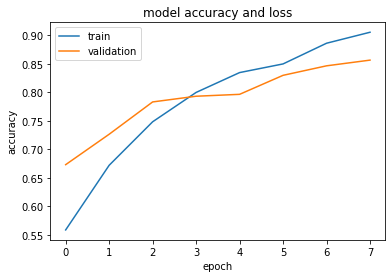

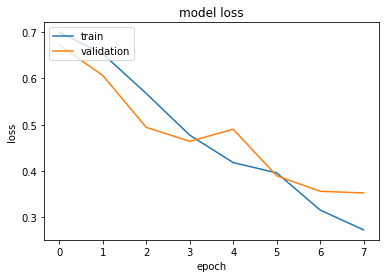

In [13]:
model,history = trainModel()
plot(history)

In [14]:
vocab_word_to_num,vocab_num_to_vector = getVocab('glove.6B.50d.txt',50)

review = "This project was fun"  # try a custom review
review = np.array([review])
review = cleanReviews(review,vocab_word_to_num)
review = tokenize(review,vocab_word_to_num,100)
print("Positive Review " if round(model.predict(review)[0][0],0) else "Negative Review ")

Positive Review 
